In [24]:
import json
import os
import csv
import urllib
from io import BytesIO
from PIL import Image

from socket import timeout

from google.colab import files

!pip3 install -q torch torchvision
import torch
from torchvision import models
from torch.utils.data import Dataset, SubsetRandomSampler, Sampler
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Download train data
!wget "https://storage.googleapis.com/dlcourse_ai/train.zip"
!unzip -q "train.zip"

train_folder = "train_kaggle/"
# Count number of files in the train folder, should be 4603
print('Number of files in the train folder', len(os.listdir(train_folder)))

# Download test data
!wget "https://storage.googleapis.com/dlcourse_ai/test.zip"
!unzip -q "test.zip"

test_folder = "test_kaggle/"
# Count number of files in the test folder, should be 1150
print('Number of files in the test folder', len(os.listdir(test_folder)))

--2022-12-17 07:42:09--  https://storage.googleapis.com/dlcourse_ai/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562348083 (536M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 536.30M  21.3MB/s    in 29s     

2022-12-17 07:42:39 (18.6 MB/s) - ‘train.zip’ saved [562348083/562348083]

Number of files in the train folder 4603
--2022-12-17 07:42:43--  https://storage.googleapis.com/dlcourse_ai/test.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 140788786 (134M) [application/zip]
Saving to: ‘test.zip’

test.z

In [3]:
device = torch.device("cuda:0")

In [4]:
class HotdogOrNotDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.transform = transform
        self.folder = folder
        self.filenames = os.listdir(folder)

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, index):        
        # TODO Implement getting item by index
        # Hint: os.path.join is helpful!
        y = 0
        img_id = self.filenames[index]
        img = Image.open(os.path.join(self.folder, img_id))
        if self.transform:
            img = self.transform(img)
        if img_id.startswith("frankfurter") or img_id.startswith("chili-dog") or img_id.startswith("hotdog"):
            y = 1
        return img, y, img_id

In [25]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset("train_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomAutocontrast()                       
                       ])
                      )

In [26]:
batch_size = 64

data_size = len(train_dataset)
validation_fraction = .2


val_split = int(np.floor((validation_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

val_indices, train_indices = indices[:val_split], indices[val_split:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                         sampler=val_sampler)

In [27]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler = None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("epoch %d Average loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (epoch+1, ave_loss, train_accuracy, val_accuracy))
        # if val_accuracy < 0.8:
        #     return loss_history, train_history, val_history

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

In [8]:
from collections import namedtuple
Hyperparams = namedtuple("Hyperparams", ['lr', 'weight_decay', 'gamma', 'step_size'])
RunResult = namedtuple("RunResult", ['val_history', 'final_val_accuracy'])
run_record = {}

In [17]:
import torch.nn as nn
import torch.optim as optim

for i in range(10):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)
    parameters = model.parameters()

    #lr = 10**np.random.uniform(-5, -6)
    lr =  4.5e-06
    weight_decay = 0.005
    gamma = 0.95
    step_size = 1
    print(f"exp {i+1}", "lr =", lr, "(gamma, step_size) =", f"({gamma},{step_size})", "weight_decay =", weight_decay)

    loss = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(parameters, lr=lr, weight_decay=weight_decay, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 7, scheduler)
    hp = Hyperparams(lr=lr, weight_decay = weight_decay, gamma=gamma, step_size = step_size)
    rr = RunResult(val_history=val_history, final_val_accuracy=val_history[-1])
    run_record[hp] = rr

exp 1 lr = 4.5e-06 (gamma, step_size) = (0.9496009472742807,1) weight_decay = 0.006476571246615638
epoch 1 Average loss: 0.227965, Train accuracy: 0.906326, val accuracy: 0.947826
epoch 2 Average loss: 0.076044, Train accuracy: 0.974206, val accuracy: 0.956522
epoch 3 Average loss: 0.051796, Train accuracy: 0.983709, val accuracy: 0.951087
epoch 4 Average loss: 0.030415, Train accuracy: 0.990768, val accuracy: 0.952174
epoch 5 Average loss: 0.024171, Train accuracy: 0.993484, val accuracy: 0.960870
epoch 6 Average loss: 0.014940, Train accuracy: 0.996742, val accuracy: 0.965217
epoch 7 Average loss: 0.009749, Train accuracy: 0.998371, val accuracy: 0.955435
exp 2 lr = 4.5e-06 (gamma, step_size) = (0.9413675711561083,1) weight_decay = 0.00023690419997418564


KeyboardInterrupt: ignored

In [18]:
result = sorted(list(run_record.items()), key=lambda x: x[1].final_val_accuracy)[::-1]
for a, b in result:
    print(a, b.final_val_accuracy)

Hyperparams(lr=4e-06, weight_decay=0.0013868520611905561, gamma=0.8402130304099891, step_size=1) 0.9641304347826087
Hyperparams(lr=3.843784469077385e-06, weight_decay=0.00016713668348481775, gamma=0.9648653783758538, step_size=1) 0.9586956521739131
Hyperparams(lr=4.5e-06, weight_decay=0.006476571246615638, gamma=0.9496009472742807, step_size=1) 0.9554347826086956


In [29]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
parameters = model.parameters()

lr =  4e-06
weight_decay = 0.0013
gamma = 0.84
step_size = 1
print(f"exp {i+1}", "lr =", lr, "(gamma, step_size) =", f"({gamma},{step_size})", "weight_decay =", weight_decay)

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(parameters, lr=lr, weight_decay=weight_decay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, 7, scheduler)

exp 2 lr = 4e-06 (gamma, step_size) = (0.84,1) weight_decay = 0.0013
epoch 1 Average loss: 0.247202, Train accuracy: 0.890578, val accuracy: 0.956522
epoch 2 Average loss: 0.091538, Train accuracy: 0.968232, val accuracy: 0.958696
epoch 3 Average loss: 0.057997, Train accuracy: 0.981808, val accuracy: 0.956522
epoch 4 Average loss: 0.043706, Train accuracy: 0.988053, val accuracy: 0.955435
epoch 5 Average loss: 0.032934, Train accuracy: 0.990497, val accuracy: 0.957609
epoch 6 Average loss: 0.023478, Train accuracy: 0.995113, val accuracy: 0.952174
epoch 7 Average loss: 0.015102, Train accuracy: 0.999185, val accuracy: 0.965217


In [30]:
def train_model(model, train_loader, loss, optimizer, num_epochs, scheduler = None, val_loader = None):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        if scheduler is not None:
            scheduler.step()
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y, _) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y_gpu.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = 0
        #val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        print("epoch %d Average loss: %f, Train accuracy: %f, val accuracy: %f" %
                  (epoch+1, ave_loss, train_accuracy, val_accuracy))
        # if val_accuracy < 0.8:
        #     return loss_history, train_history, val_history

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y, _) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]

    train_accuracy = float(correct_samples) / total_samples
    return train_accuracy

In [31]:
# First, lets load the dataset
train_dataset = HotdogOrNotDataset("train_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                 
                       ])
                      )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
loss_history, train_history, val_history = train_model(model, train_loader, loss, optimizer, 5, scheduler)

epoch 1 Average loss: 0.009776, Train accuracy: 0.998914, val accuracy: 0.000000
epoch 2 Average loss: 0.007539, Train accuracy: 1.000000, val accuracy: 0.000000
epoch 3 Average loss: 0.005765, Train accuracy: 1.000000, val accuracy: 0.000000
epoch 4 Average loss: 0.005207, Train accuracy: 1.000000, val accuracy: 0.000000
epoch 5 Average loss: 0.003922, Train accuracy: 1.000000, val accuracy: 0.000000


In [32]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()
    predictions = []
    ground_truth = []
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=sampler)
    for i_step, (x, y, _) in enumerate(loader):
        prediction = model(x)
        _, ind = torch.max(prediction, 1)
        predictions.extend(ind)
        ground_truth.extend(y)

    return predictions, ground_truth

model.to('cpu')
predictions, gt = evaluate_model(model, train_dataset, val_indices)

def binary_classification_metrics(prediction, ground_truth):
    if type(prediction) == type(list()):
      prediction = np.array(prediction)
    if type(ground_truth) == type(list()):
      ground_truth = np.array(ground_truth)
    precision = np.sum(prediction & ground_truth) / np.sum(prediction)
    recall = np.sum(prediction & ground_truth) / np.sum(ground_truth)
    f1 = 2 / (1/precision + 1/recall)

    return precision, recall, f1


precision, recall, f1 = binary_classification_metrics(predictions, gt)
print("F1: %4.3f, P: %4.3f, R: %4.3f" % (f1, precision, recall))

F1: 0.940, P: 0.959, R: 0.921


Визуализируйте ошибки лучшей модели


In [35]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))        
    for i, index in enumerate(display_indices):    
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')

class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval()
    predictions = []
    ground_truth = []
    sampler = SubsetSampler(indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=sampler)
    for i_step, (x, y, _) in enumerate(loader):
        prediction = model(x)
        _, ind = torch.max(prediction, 1)
        predictions.extend(ind)
        ground_truth.extend(y)

    return predictions, ground_truth

predictions, gt = evaluate_model(model, train_dataset, val_indices)

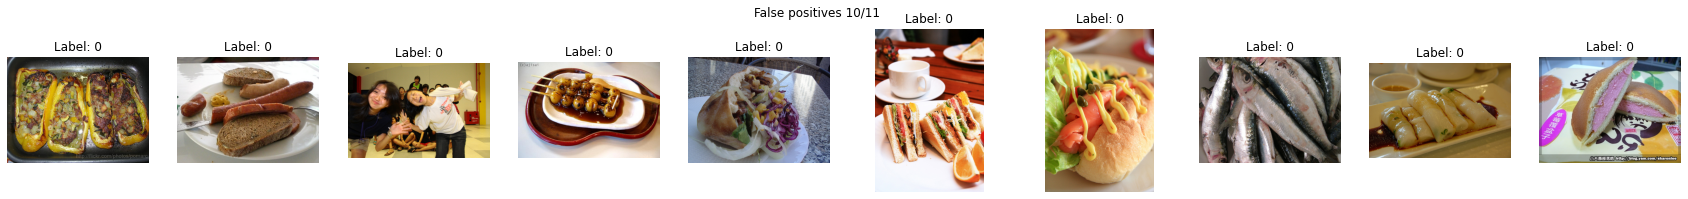

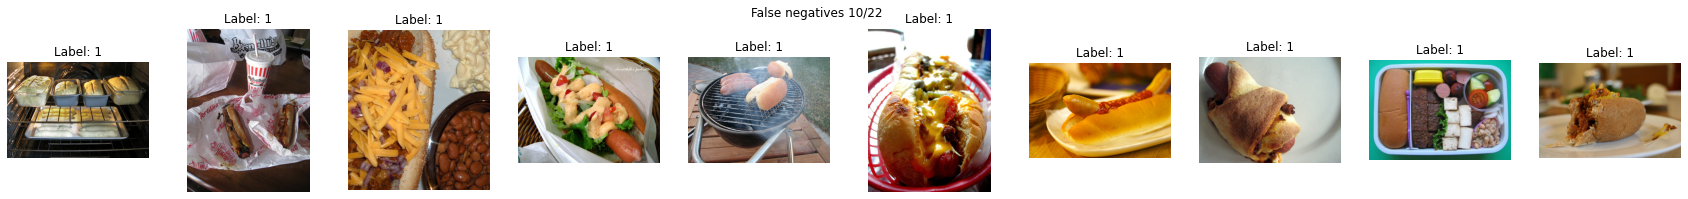

In [37]:
orig_dataset = HotdogOrNotDataset("train_kaggle")
false_positive_indices = np.array(val_indices)[np.array([bool(p) and not bool(r) for p, r in zip(predictions, gt)])]
visualize_samples(orig_dataset, false_positive_indices, "False positives")

false_negatives_indices = np.array(val_indices)[np.array([not bool(p) and bool(r) for p, r in zip(predictions, gt)])]
visualize_samples(orig_dataset, false_negatives_indices, "False negatives")

In [42]:
test_dataset = HotdogOrNotDataset("test_kaggle",
                       transform=transforms.Compose([
                           transforms.Resize((224, 224)),
                           transforms.ToTensor(),
                           # Use mean and std for pretrained models
                           # https://pytorch.org/docs/stable/torchvision/models.html
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])                         
                       ])
                      )
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [47]:
image_id = []
predictions = []
model.eval()
for x,_,id_img in test_loader:
    prediction = model(x)
    _, indices = torch.max(prediction, 1)
    predictions.extend(indices.numpy())
    image_id.extend(id_img)
print(predictions[:5])
print(image_id[:5])

[1, 0, 1, 1, 0]
['10613.jpg', '10472.jpg', '10096.jpg', '10690.jpg', '10046.jpg']


In [48]:
# Так можно создать csv файл, чтобы затем загрузить его на kaggle
# Ожидаемый формат csv-файла:
# image_id,label
# 10000.jpg,1
# 10001.jpg,1
# 10002.jpg,0
# 10003.jpg,1
# 10004.jpg,0

with open('subm.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerow(['image_id', 'label'])
    writer.writerows(zip(image_id,predictions))

In [49]:
# А так можно скачать файл с Google Colab
files.download('subm.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>